### Imports & Display Options

In [2]:
%matplotlib inline
import pandas as pd
pd.options.display.max_columns = 999
pd.options.display.max_rows = 100

In [3]:
from matplotlib import pylab

In [15]:
import numpy as np
import feather
from datetime import datetime
import re

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

In [1]:
from keras.utils import np_utils
from keras.layers import LSTM, Convolution1D, Flatten, Dropout, Dense
from keras.layers.embeddings import Embedding
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot
from keras.callbacks import TensorBoard

Using TensorFlow backend.


### Import Data & Clean

In [3]:
df = pd.read_csv('./BasicCompanyDataAsOneFile-2018-03-01.csv', nrows=1000000)
df.head()

/Users/zeb.zhao/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (41,42,43,44,45,46,47,48,49,50,51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,CompanyName,CompanyNumber,RegAddress.CareOf,RegAddress.POBox,RegAddress.AddressLine1,RegAddress.AddressLine2,RegAddress.PostTown,RegAddress.County,RegAddress.Country,RegAddress.PostCode,CompanyCategory,CompanyStatus,CountryOfOrigin,DissolutionDate,IncorporationDate,Accounts.AccountRefDay,Accounts.AccountRefMonth,Accounts.NextDueDate,Accounts.LastMadeUpDate,Accounts.AccountCategory,Returns.NextDueDate,Returns.LastMadeUpDate,Mortgages.NumMortCharges,Mortgages.NumMortOutstanding,Mortgages.NumMortPartSatisfied,Mortgages.NumMortSatisfied,SICCode.SicText_1,SICCode.SicText_2,SICCode.SicText_3,SICCode.SicText_4,LimitedPartnerships.NumGenPartners,LimitedPartnerships.NumLimPartners,URI,PreviousName_1.CONDATE,PreviousName_1.CompanyName,PreviousName_2.CONDATE,PreviousName_2.CompanyName,PreviousName_3.CONDATE,PreviousName_3.CompanyName,PreviousName_4.CONDATE,PreviousName_4.CompanyName,PreviousName_5.CONDATE,PreviousName_5.CompanyName,PreviousName_6.CONDATE,PreviousName_6.CompanyName,PreviousName_7.CONDATE,PreviousName_7.CompanyName,PreviousName_8.CONDATE,PreviousName_8.CompanyName,PreviousName_9.CONDATE,PreviousName_9.CompanyName,PreviousName_10.CONDATE,PreviousName_10.CompanyName,ConfStmtNextDueDate,ConfStmtLastMadeUpDate
0,! LTD,08209948,NaN,NaN,METROHOUSE 57 PEPPER ROAD,HUNSLET,LEEDS,YORKSHIRE,NaN,LS10 2RU,Private Limited Company,Active,United Kingdom,NaN,11/09/2012,30.0,9.0,30/06/2018,30/09/2016,DORMANT,09/10/2016,11/09/2015,0,0,0,0,99999 - Dormant Company,NaN,NaN,NaN,0,0,http://business.data.gov.uk/id/company/08209948,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25/09/2019,11/09/2017
1,!NNOV8 LIMITED,11006939,NaN,NaN,C/O FRANK HIRTH 1ST FLOOR,236 GRAY'S INN ROAD,LONDON,NaN,UNITED KINGDOM,WC1X 8HB,Private Limited Company,Active,United Kingdom,NaN,11/10/2017,31.0,3.0,11/07/2019,NaN,NO ACCOUNTS FILED,08/11/2018,NaN,0,0,0,0,62090 - Other information technology service a...,NaN,NaN,NaN,0,0,http://business.data.gov.uk/id/company/11006939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24/10/2019,NaN
2,!NSPIRED LTD,SC421617,NaN,NaN,26 POLMUIR ROAD,NaN,ABERDEEN,NaN,UNITED KINGDOM,AB11 7SY,Private Limited Company,Active,United Kingdom,NaN,11/04/2012,30.0,3.0,30/12/2018,30/03/2017,TOTAL EXEMPTION FULL,09/05/2017,11/04/2016,0,0,0,0,70229 - Management consultancy activities othe...,NaN,NaN,NaN,0,0,http://business.data.gov.uk/id/company/SC421617,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25/04/2020,11/04/2017
3,!NVERTD DESIGNS LIMITED,09152972,NaN,NaN,55A HIGH STREET,NaN,SILSOE,BEDFORDSHIRE,NaN,MK45 4EW,Private Limited Company,Active,United Kingdom,NaN,30/07/2014,31.0,7.0,30/04/2019,31/07/2017,NaN,27/08/2016,30/07/2015,0,0,0,0,58190 - Other publishing activities,NaN,NaN,NaN,0,0,http://business.data.gov.uk/id/company/09152972,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13/08/2020,30/07/2017
4,!OBAC LIMITED,FC031362,NaN,NaN,1ST AND 2ND FLOORS ELIZABETH HOUSE,LES RUETIES BRAYES,ST PETER PORT,GUERNSEY,GUERNSEY,GY1 1EW,Other company type,Active,CHANNEL ISLANDS,NaN,30/11/2012,31.0,12.0,NaN,31/12/2016,GROUP,NaN,NaN,0,0,0,0,None Supplied,NaN,NaN,NaN,0,0,http://business.data.gov.uk/id/company/FC031362,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
def clean(df):
    wdf = df[~df.CompanyName.str.contains('!')].dropna(subset=['Returns.LastMadeUpDate'])
    wdf = wdf[['CompanyName', 'SICCode.SicText_1']]
    wdf['CompanyName'] = wdf.CompanyName.str.replace('[".,()\']', ' ')\
        .str.replace('\s+', ' ').str.strip()\
        .str.replace('LIMITED', 'LTD')\
        .str.replace('INCORPORATED', 'INC')\
        .str.replace('([A-Z])LTD', '\\1 LTD')
    SICC = wdf['SICCode.SicText_1'].str.split(' - ').str[0]
    wdf = wdf[(SICC != '99999') & SICC.str.isnumeric()]
    wdf = wdf[wdf.CompanyName.str.count(' ') < 8]
    return wdf

In [5]:
wdf = clean(df)

### Check for Class Imbalance

In [28]:
def plot_frequency(df, top=50):
    classes = df.groupby(['SICCode.SicText_1']).count().sort_values('CompanyName', ascending=False)
    return classes.head(top).plot(kind='bar', figsize=(10, 3))

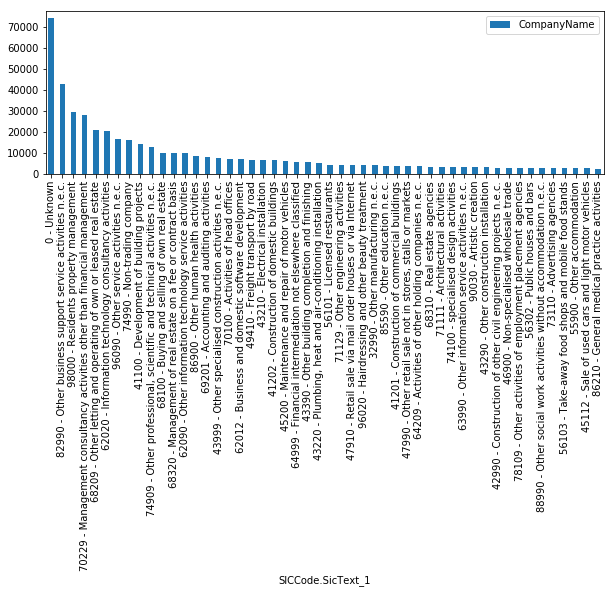

In [29]:
plot_frequency(wdf)

In [19]:
min_class_count = 500
print(' Classes below %s samples: %s/%s' % (min_class_count, (classes.CompanyName < min_class_count).sum(), len(classes.CompanyName)))

 Classes below 500 samples: 916/1098


In [20]:
classes[classes.CompanyName < min_class_count].sum()

CompanyName    74227
dtype: int64

### Resample Data

In [23]:
to_replace = classes[classes.CompanyName < min_class_count].index

In [26]:
wdf['SICCode.SicText_1'] = wdf['SICCode.SicText_1'].replace(to_replace, '0 - Unknown')

In [ ]:
plot_frequency(wdf)

In [37]:
def resample_class(df, y_value, freq=0.5):
    np.random.seed(0)
    criteria = np.random.rand(len(df)) < freq
    return df[(df['SICCode.SicText_1'] != y_value) | criteria]

In [35]:
classes.sort_values('CompanyName', ascending=False)

,CompanyName
SICCode.SicText_1,
82990 - Other business support service activities n.e.c.,42736
98000 - Residents property management,29481
70229 - Management consultancy activities other than financial management,28168
68209 - Other letting and operating of own or leased real estate,21073
62020 - Information technology consultancy activities,20159
96090 - Other service activities n.e.c.,16726
74990 - Non-trading company,16184
41100 - Development of building projects,14030
"74909 - Other professional, scientific and technical activities n.e.c.",12875


In [38]:
wdf = resample_class(wdf, '0 - Unknown', freq=0.33)
wdf = resample_class(wdf, '82990 - Other business support service activities n.e.c.', freq=0.66)

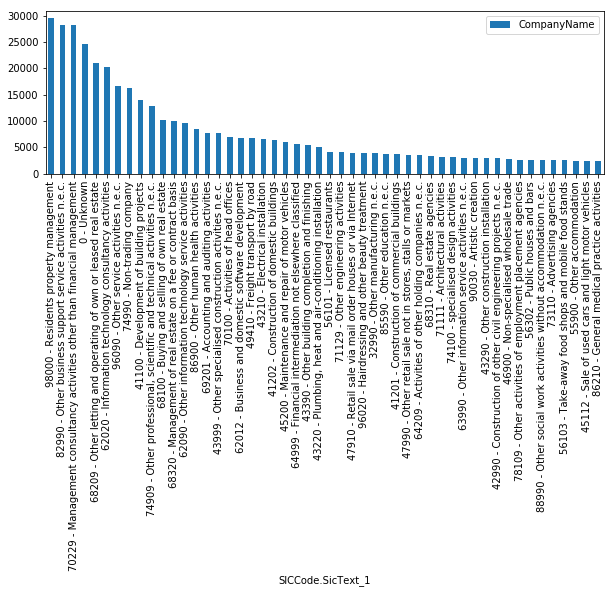

In [39]:
plot_frequency(wdf)

### Pickle Working Set

In [71]:
feather.write_dataframe(wdf, 'wdf.feather')

In [18]:
wdf = feather.read_dataframe('wdf.feather')
wdf.head()

,CompanyName,SICCode.SicText_1
0,1 C O LTD,70229 - Management consultancy activities othe...
1,243 RUGBY ROAD MANAGEMENT COMPANY LTD,98000 - Residents property management
2,309 WEST END LANE MANAGEMENT LTD,98000 - Residents property management
3,A TASTE OF TUSCANY LTD,56101 - Licensed restaurants
4,A CERAMICS LTD,86230 - Dental practice activities


### Label Encoding

In [28]:
encoder = LabelEncoder()
encoder.fit(wdf['SICCode.SicText_1'])
encoded_Y = encoder.transform(wdf['SICCode.SicText_1'])
labels = np_utils.to_categorical(encoded_Y)
labels.shape

(546800, 183)

In [29]:
num_classes = labels.shape[1]

### Text Encoding

In [6]:
def load_glove_embeddings(fp, embedding_dim, include_empty_char=True):
    """
    Loads pre-trained word embeddings (GloVe embeddings)
        Inputs: - fp: filepath of pre-trained glove embeddings
                - embedding_dim: dimension of each vector embedding
                - generate_matrix: whether to generate an embedding matrix
        Outputs:
                - word2coefs: Dictionary. Word to its corresponding coefficients
                - word2index: Dictionary. Word to word-index
                - embedding_matrix: Embedding matrix for Keras Embedding layer
    """
    # First, build the "word2coefs" and "word2index"
    word2coefs = {} # word to its corresponding coefficients
    word2index = {} # word to word-index
    with open(fp) as f:
        for idx, line in enumerate(f):
            try:
                data = [x.strip().lower() for x in line.split()]
                word = data[0]
                coefs = np.asarray(data[1:embedding_dim+1], dtype='float32')
                word2coefs[word] = coefs
                if word not in word2index:
                    word2index[word] = len(word2index)
            except Exception as e:
                print('Exception occurred in `load_glove_embeddings`:', e)
                continue
        # End of for loop.
    # End of with open
    if include_empty_char:
        word2index[''] = len(word2index)
    # Second, build the "embedding_matrix"
    # Words not found in embedding index will be all-zeros. Hence, the "+1".
    vocab_size = len(word2coefs)+1 if include_empty_char else len(word2coefs)
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, idx in word2index.items():
        embedding_vec = word2coefs.get(word)
        if embedding_vec is not None and embedding_vec.shape[0]==embedding_dim:
            embedding_matrix[idx] = np.asarray(embedding_vec)
    # return word2coefs, word2index, embedding_matrix
    return word2index, np.asarray(embedding_matrix)

In [7]:
word2index, embedding_matrix = load_glove_embeddings('glove.6B/glove.6B.50d.txt', embedding_dim=50)

In [23]:
def custom_tokenize(d):
    return [word2index.get(re.sub(r'[^\w\s]','',w).lower(), 0) for w in d.split()]

In [34]:
vocab_size, embedding_dim = embedding_matrix.shape
maxlen = 10
print(custom_tokenize('This is an apple'))
print(custom_tokenize('what is this, an apple?'))

[37, 14, 29, 3292]
[102, 14, 37, 29, 3292]


In [25]:
encoded_company_names = [custom_tokenize(d) for d in wdf.CompanyName]
encoded_company_names = [d for d in encoded_company_names]

In [26]:
encoded_company_names = pad_sequences(encoded_company_names, maxlen=maxlen, padding='post')

In [30]:
# Sanity check
len(encoded_company_names), len(labels)

(546800, 546800)

### Train/Test Split

In [32]:
X_train, X_test, y_train, y_test = train_test_split(
    encoded_company_names, labels, test_size=0.25, random_state=42)
y_train.shape

(410100, 183)

### Model

In [37]:
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen,
                            weights=[embedding_matrix], trainable=False)
model = Sequential()
model.add(embedding_layer)
model.add(Flatten())
model.add(Dense(num_classes, activation='sigmoid'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 10, 50)            20000050  
_________________________________________________________________
flatten_2 (Flatten)          (None, 500)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 183)               91683     
Total params: 20,091,733
Trainable params: 91,683
Non-trainable params: 20,000,050
_________________________________________________________________


### Hook up Tensorboard

`tensorboard --logdir='tmp'`

In [39]:
date_suffix = str(datetime.now()).replace(':', '-').split('.')[0]
temp_folder = 'tmp/GloVe%s-flatten-dense%s-%s' % (
    embedding_dim, num_classes, date_suffix)
temp_folder

'tmp/GloVe50-flatten-dense183-2018-03-21 15-30-32'

### Train Model

In [40]:
model.fit(
    X_train, y_train, epochs=5,
    validation_data=(X_test, y_test),
    callbacks=[TensorBoard(log_dir=temp_folder)])

Train on 410100 samples, validate on 136700 samples
Epoch 1/25
410100/410100 [==============================] - 36s 88us/step - loss: 3.6653 - acc: 0.1964 - val_loss: 3.5193 - val_acc: 0.2224
Epoch 2/25
410100/410100 [==============================] - 36s 89us/step - loss: 3.5045 - acc: 0.2192 - val_loss: 3.5163 - val_acc: 0.2186
Epoch 3/25
410100/410100 [==============================] - 36s 88us/step - loss: 3.4865 - acc: 0.2223 - val_loss: 3.5073 - val_acc: 0.2161
Epoch 4/25
410100/410100 [==============================] - 36s 89us/step - loss: 3.4777 - acc: 0.2235 - val_loss: 3.5144 - val_acc: 0.2222
Epoch 5/25
410100/410100 [==============================] - 36s 87us/step - loss: 3.4734 - acc: 0.2246 - val_loss: 3.5195 - val_acc: 0.2254
Epoch 6/25
410100/410100 [==============================] - 36s 88us/step - loss: 3.4704 - acc: 0.2245 - val_loss: 3.5177 - val_acc: 0.2211
Epoch 7/25
410100/410100 [==============================] - 36s 88us/step - loss: 3.4677 - acc: 0.2256 - val

### Testing/Validation

In [42]:
loss, accuracy = model.evaluate(X_test, y_test)
accuracy

136700/136700 [==============================] - 4s 31us/step


0.22646671543569571

In [43]:
y_labels = np.argmax(y_test, axis=1)
y_pred = model.predict_classes(X_test)
y_labels.shape, y_pred.shape

((136700,), (136700,))

In [44]:
print('Verifying accuracy', (y_labels==y_pred).sum()/len(y_pred))

Verifying accuracy 0.226466715435


In [45]:
def plot_confusion_matrix(cm, classes):
    pylab.clf()
    pylab.matshow(cm, fignum=False, cmap='Blues', vmin=0, vmax=0.6)
    pylab.colorbar()
    pylab.grid(False)
    pylab.xlabel('Predicted')
    pylab.ylabel('Actual')
    pylab.show()

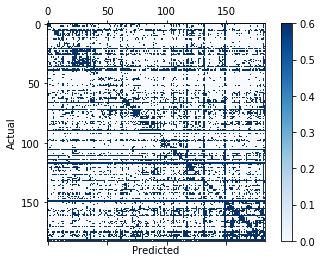

In [46]:
plot_confusion_matrix(confusion_matrix(y_pred, y_labels), [])

### Save Model

In [47]:
model.save('models/train%s-acc%s.h5' % (len(X_train), accuracy))

### Play With Model

In [ ]:
while True:
    name = input()
    if not name:
        break
    encoded_company_name = pad_sequences([custom_tokenize(name)], maxlen=maxlen, padding='post')
    print(encoder.inverse_transform(model.predict_classes(encoded_company_name)))

Bob's Haircut
['96020 - Hairdressing and other beauty treatment']
Bob's Salon
['96020 - Hairdressing and other beauty treatment']
Bob's Pizza
['56103 - Take-away food shops and mobile food stands']
Bob's Auto
['45200 - Maintenance and repair of motor vehicles']
Bob's Market
['62020 - Information technology consultancy activities']
Bob's Kebabs
['56103 - Take-away food shops and mobile food stands']
Bob's Fries
['56103 - Take-away food shops and mobile food stands']
Microsoft
['62020 - Information technology consultancy activities']
Apple
['62020 - Information technology consultancy activities']
Google
['62020 - Information technology consultancy activities']
Shopper's Drugmart
['94910 - Activities of religious organizations']
St Paul's
['94910 - Activities of religious organizations']
Church of Jesus
['94910 - Activities of religious organizations']
Bob's Bistro
['56101 - Licensed restaurants']
Bob's Cafe
['56101 - Licensed restaurants']
Thai Express
['56103 - Take-away food shops and 